In [3]:
import pandas as pd
import numpy as np
import os
import warnings
from datetime import datetime
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import itertools # For hyperparameter tuning loop
import seaborn as sns

In [4]:

warnings.filterwarnings('ignore')

# --- Configuration ---
FILE_PATH = '../../dataset/results0/AAPL_yahoo_data_0.csv'  # <--- CHANGE THIS TO YOUR FILE PATH
TARGET_COLUMN = 'Adj Close' # Needed to calculate returns
RETURN_COLUMN = 'Daily Return'
TRAIN_SIZE_RATIO = 0.8


Starting GARCH Baseline Evaluation...
Data loaded successfully. Shape: (3328, 14)
Total return data points: 3328
Training split index: 2662 (Using first 80%)

--- Tuning and Evaluating GARCH for Volatility ---
Tuning GARCH(p,q) order on initial training data...
  New best order found: (1, 0) (AIC: 10566.57)
  New best order found: (1, 1) (AIC: 10264.72)
Best GARCH order found: (1, 1) (Based on AIC on initial train set)
Tuning finished. Time elapsed: 0:00:00.319349


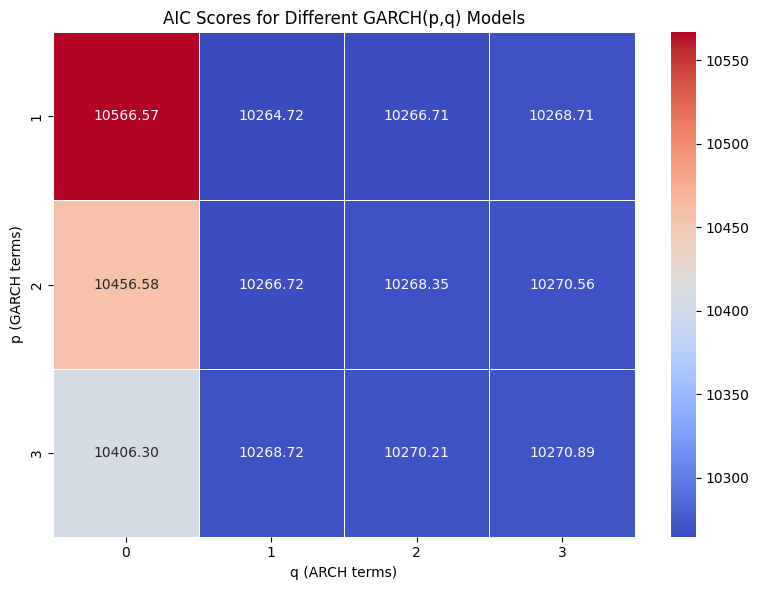

Saved AIC heatmap to garch_aic_heatmap.png
Starting walk-forward validation using GARCH(1, 1)...
  Processed 100/666 steps...
  Processed 200/666 steps...
  Processed 300/666 steps...
  Processed 400/666 steps...
  Processed 500/666 steps...
  Processed 600/666 steps...
Walk-forward validation complete. Time elapsed: 0:00:09.387554
--- GARCH(1, 1) Variance Metrics ---
GARCH(1, 1)_Variance_MAE: 2.930949
GARCH(1, 1)_Variance_RMSE: 5.819325
----------------------------------
Saved GARCH volatility plot to garch_volatility_predictions.png

GARCH Best Parameters (Order p,q): (1, 1)

--- Final GARCH Metrics ---
   GARCH(1, 1)_Variance_MAE  GARCH(1, 1)_Variance_RMSE
0                  2.930949                   5.819325

GARCH evaluation complete. Metrics saved to garch_baseline_metrics.csv


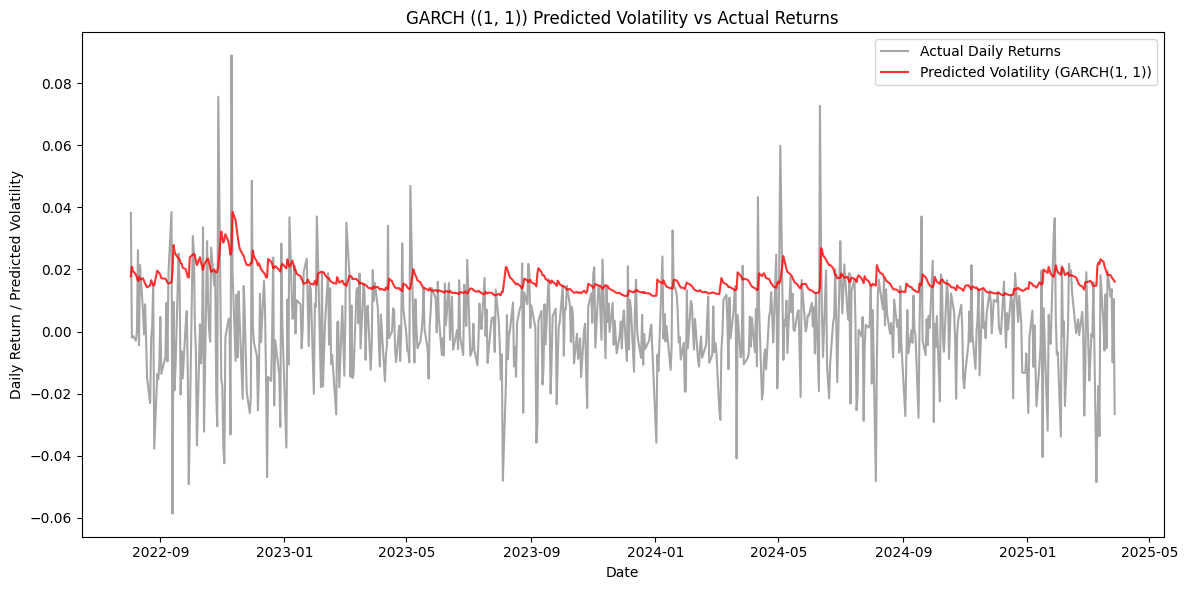

In [5]:

# --- Utility Functions ---

def load_data(filepath):
    """Loads data, sets index, calculates returns, handles cleaning."""
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Data file not found at {filepath}")
    try:
        df = pd.read_csv(filepath, index_col='Date', parse_dates=True)
        # if df.index is not None:
        #     print("Converting index to timezone naive (UTC representation)")
        #     df.index = df.index.tz_convert(None)

        if TARGET_COLUMN not in df.columns:
             raise ValueError(f"Target column '{TARGET_COLUMN}' not found.")
        df[TARGET_COLUMN] = pd.to_numeric(df[TARGET_COLUMN], errors='coerce')

        # Calculate Daily Return if not present, handle potential division by zero
        if RETURN_COLUMN not in df.columns:
             print(f"Calculating {RETURN_COLUMN}")
             df[RETURN_COLUMN] = df[TARGET_COLUMN].pct_change().fillna(0) # Fill initial NaN with 0
             # Replace inf/-inf that might arise from 0 division if price was 0
             df[RETURN_COLUMN].replace([np.inf, -np.inf], 0, inplace=True)

        # Ensure return column is numeric
        df[RETURN_COLUMN] = pd.to_numeric(df[RETURN_COLUMN], errors='coerce')

        df.ffill(inplace=True) # Fill other potential NaNs
        df.dropna(subset=[RETURN_COLUMN], inplace=True) # Drop if return couldn't be calculated
        print(f"Data loaded successfully. Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def calculate_variance_metrics(y_true_var, y_pred_var, model_name="Model"):
    """Calculates MAE and RMSE for variance predictions."""
    mae_var = mean_absolute_error(y_true_var, y_pred_var)
    mse_var = mean_squared_error(y_true_var, y_pred_var)
    rmse_var = np.sqrt(mse_var)
    metrics = {
        f'{model_name}_Variance_MAE': mae_var,
        f'{model_name}_Variance_RMSE': rmse_var,
    }
    print(f"--- {model_name} Variance Metrics ---")
    for k, v in metrics.items(): print(f"{k}: {v:.6f}") # More precision for variance
    print("-" * (len(model_name) + 23))
    return metrics

# --- GARCH Model with Tuning and Walk-Forward Evaluation ---

def tune_evaluate_garch(returns, train_size):
    """Tunes GARCH(p,q) order and evaluates variance forecast using walk-forward."""
    print("\n--- Tuning and Evaluating GARCH for Volatility ---")
    # GARCH needs returns, often scaled by 100 for better convergence
    returns_scaled = returns * 100
    train_returns, test_returns = returns_scaled[:train_size], returns_scaled[train_size:]
    history = train_returns.copy().values # Use numpy array for arch library

    # --- Hyperparameter Tuning: Find best GARCH(p,q) order ---
    print("Tuning GARCH(p,q) order on initial training data...")
    p_range = range(1, 4) # Test p from 1 to 3
    q_range = range(0, 4) # Test q from 0 to 3 (q=0 is ARCH)
    best_aic = np.inf
    best_order = (1, 1) # Default fallback

    start_tune_time = datetime.now()
    for p, q in itertools.product(p_range, q_range):
        if p == 0 and q == 0: continue # Skip (0,0)
        try:
            # Fit on initial training data only for tuning
            model = arch_model(history, vol='Garch', p=p, q=q, rescale=False)
            model_fit = model.fit(disp='off')
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = (p, q)
                print(f"  New best order found: {best_order} (AIC: {best_aic:.2f})")
        except Exception:
            # Ignore orders that fail to converge during tuning
            # print(f"  Order ({p},{q}) failed during tuning.")
            continue

    print(f"Best GARCH order found: {best_order} (Based on AIC on initial train set)")
    print(f"Tuning finished. Time elapsed: {datetime.now() - start_tune_time}")

    # Collect all AIC values for plotting
    aic_results = []
    for p, q in itertools.product(p_range, q_range):
        if p == 0 and q == 0: continue
        try:
            model = arch_model(history, vol='Garch', p=p, q=q, rescale=False)
            model_fit = model.fit(disp='off')
            aic_results.append({'p': p, 'q': q, 'AIC': model_fit.aic})
        except:
            continue

    if aic_results:
        aic_df = pd.DataFrame(aic_results)
        
        # Create pivot for heatmap
        pivot_table = aic_df.pivot(index='p', columns='q', values='AIC')
        
        # Plot heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
        plt.title("AIC Scores for Different GARCH(p,q) Models")
        plt.xlabel("q (ARCH terms)")
        plt.ylabel("p (GARCH terms)")
        plt.tight_layout()
        plt.savefig("garch_aic_heatmap.png")
        plt.show()
        print("Saved AIC heatmap to garch_aic_heatmap.png")

    # --- Walk-Forward Validation with Best Order ---
    print(f"Starting walk-forward validation using GARCH{best_order}...")
    predictions_var = [] # Store predicted variance
    history = train_returns.copy().values # Reset history for evaluation walk-forward

    start_eval_time = datetime.now()
    for t in range(len(test_returns)):
        try:
            # Rescale=False as returns are already scaled by 100
            model = arch_model(history, vol='Garch', p=best_order[0], q=best_order[1], rescale=False)
            model_fit = model.fit(disp='off')
            # Forecast 1 step ahead variance
            pred_var = model_fit.forecast(horizon=1, reindex=False).variance.iloc[-1, 0]
            predictions_var.append(pred_var)
            history = np.append(history, test_returns.iloc[t]) # Append actual scaled return
        except Exception as e:
            print(f"Warning: GARCH fit/forecast failed at step {t+1}/{len(test_returns)}. Error: {e}. Appending NaN.")
            predictions_var.append(np.nan)
            history = np.append(history, test_returns.iloc[t]) # Still append actual

        if (t + 1) % 100 == 0:
             print(f"  Processed {t+1}/{len(test_returns)} steps...")

    print(f"Walk-forward validation complete. Time elapsed: {datetime.now() - start_eval_time}")

    # --- Evaluate ---
    # Compare predicted variance with squared actual returns (proxy for realized variance)
    # Remember predictions_var are based on returns*100, so compare with (test_returns*100)^2
    realized_var = test_returns**2

    predictions_var_array = np.array(predictions_var)
    valid_indices = ~np.isnan(predictions_var_array)
    if not np.any(valid_indices):
        print("GARCH failed to produce any valid variance predictions.")
        return None, best_order

    y_true_valid_var = realized_var.iloc[valid_indices]
    y_pred_valid_var = predictions_var_array[valid_indices]

    # Note: Predicted variance can be very small, check for zeros if issues arise
    # y_pred_valid_var[y_pred_valid_var <= 0] = 1e-9 # Replace non-positive variance if needed

    metrics = calculate_variance_metrics(y_true_valid_var, y_pred_valid_var, f"GARCH{best_order}")

    # --- Plotting (Optional) ---
    # Plot actual returns vs predicted volatility (sqrt of variance)
    predicted_vol = np.sqrt(y_pred_valid_var)
    plt.figure(figsize=(12, 6))
    plt.plot(test_returns.index, test_returns.values / 100, label='Actual Daily Returns', alpha=0.7, color='grey')
    plt.plot(test_returns.index[valid_indices], predicted_vol / 100, label=f'Predicted Volatility (GARCH{best_order})', alpha=0.8, color='red')
    plt.title(f'GARCH ({best_order}) Predicted Volatility vs Actual Returns')
    plt.xlabel('Date')
    plt.ylabel('Daily Return / Predicted Volatility')
    plt.legend()
    plt.tight_layout()
    # plt.savefig('garch_volatility_predictions.png')
    plt.plot()
    # plt.close()
    print("Saved GARCH volatility plot to garch_volatility_predictions.png")

    return metrics, best_order

# --- Main Execution ---
if __name__ == "__main__":
    print("Starting GARCH Baseline Evaluation...")
    df_full = load_data(FILE_PATH)
    returns = df_full[RETURN_COLUMN].dropna() # Ensure no NaNs in returns

    n = len(returns)
    train_split_index = int(n * TRAIN_SIZE_RATIO)
    print(f"Total return data points: {n}")
    print(f"Training split index: {train_split_index} (Using first {TRAIN_SIZE_RATIO*100:.0f}%)")

    all_metrics = {}
    try:
        garch_metrics, garch_order = tune_evaluate_garch(returns, train_split_index)
        if garch_metrics:
            all_metrics.update(garch_metrics)
            print(f"\nGARCH Best Parameters (Order p,q): {garch_order}")
            metrics_df = pd.DataFrame([all_metrics])
            print("\n--- Final GARCH Metrics ---")
            print(metrics_df.to_string())
            metrics_df.to_csv('garch_baseline_metrics.csv', index=False)
            print("\nGARCH evaluation complete. Metrics saved to garch_baseline_metrics.csv")
        else:
            print("\nGARCH evaluation failed.")

    except Exception as e:
        print(f"\nAn error occurred during the GARCH process: {e}")